<a href="https://colab.research.google.com/github/DiegoHuesos/Tesis_deteccion_de_ruido_en_imagenes_con_algoritmo_paralelo_de_agrupamiento/blob/master/Implementacion_Experimentacion_Paralela_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación y experimentación del algoritmo **paralelo** DBSCAN con CUDA

En el presente código, se programa y se explica paso a paso el algoritmo `DBSCAN` que, cierta parte, se ejecuta de forma paralela. Esta implementación se basa en la propuesta inicial de [1996 by Ester et. al](https://dl.acm.org/doi/10.5555/3001460.3001507), razón por la cual, no es la implementación más óptima en la actualidad. Además, se tomó como código base el [ejercicio de DBSCAN de domino.ai](https://colab.research.google.com/github/hpcgarage/pyboot-g2s3/blob/master/supplemental/dbscan--soln.ipynb#scrollTo=VZq1TBFlwYJZ).

Es decir, se toma como base la implementación serial hecha previamente, pero se modifica el cáluclo de las distancias y la determinación de vecindad para que se ejecuten de forma paralela en la GPU.

Posteriormente, se llevan a cabo distintos experimentos para medir el tiempo de ejecución y el uso de la memoria al ejecutar el algoritmo `DBSCAN` paralelo.

Se llevan a cabo dos experimentos principales: por un lado, se utilizan los conjuntos de datos de muestra (Toy Datasets) de la librería `sklearn`; por otro lado, se utilizan los conjuntos de datos sintéticos creados previamente con la función de `make_blobs()` que viene por defecto en la librería `sklearn`.

En ambos casos, se ejecuta 30 veces la función `dbscan()` paralela para cada conjunto de datos, se mide el tiempo de ejecución y el uso de la memoria, y, por último, se guardan los resultados en archivos en formato `JSON` para su posterior análisis en conjunto con otros resultados experimentales.

La razón por la cual se determina que 30 es el número de repeticiones adecuado para la experimentación es porque este es un número comúnmente utilizado en experimentos para obtener una estimación fiable. La justificación estadística para 30 repeticiones se debe a que se considera que proporciona una muestra suficientemente grande para que el Teorema del Límite Central se aplique, permitiendo que se utilicen análisis paramétricos, asumiendo una distribución normal de los resultados.



## Importación de librerías y declaración de funciones para graficar resultados y medir uso de memoria

In [ ]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=d5d8d18c716ebdb34685af85875ef780fa7cd30bb911915a03f7d51e8d481645
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import time
import json
import psutil
import os
import gc
import pynvml

from numba import cuda
from sklearn import datasets
from sklearn.datasets import make_blobs
from operator import indexOf
from IPython.display import display
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [ ]:
def make_scatter_plot(df, title, hue='kmeans_label'):
    # Check if 'kmeans_label' exists in the DataFrame
    if hue not in df.columns:
        raise ValueError(f"'{hue}' column not found in the DataFrame.")

    # Create the scatter plot
    plt.figure(figsize=(8, 6))  # Set the figure size

    # Use seaborn's scatterplot function
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], hue=df[hue])

    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.legend(title=hue)  # Display legend with specified title
    plt.show()

def plot_dbscan_results(X_std, labels, core_samples_mask):
    # Unique labels
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        # Plot core samples
        xy = X_std[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        # Plot non-core samples
        xy = X_std[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('DBSCAN clustering')
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.show()

def plot_labels (df, labels, title):
    df_labeled = df.copy ()
    df_labeled['label'] = labels
    make_scatter_plot(df_labeled, title, hue="label")

In [ ]:
def get_total_memory():
    return psutil.virtual_memory().total / (1024 * 1024)

def get_memory_usage_percentage():
    return psutil.virtual_memory().percent

def get_gpu_memory_info(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)  # Obtiene el handle de la GPU especificada
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)  # Obtiene la información de memoria de la GPU
    gpu_memory_info = {
                          "total_vram_gb": info.total / (1024 ** 3),
                          "used_vram_gb": info.used / (1024 ** 3),
                          "free_vram_gb": info.free / (1024 ** 3)
                      }

    pynvml.nvmlShutdown()
    return gpu_memory_info

def get_gpu_memory_percentage(device_index=0):
    gpu_memory_info = get_gpu_memory_info()
    return round( gpu_memory_info['used_vram_gb'] / gpu_memory_info['total_vram_gb'] * 100, 1 )

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return cpu_usage

## Implementación del algoritmo paralelo DBSCAN

DBSCAN identifica clusters basándose en la densidad de los puntos de datos, lo que le permite descubrir grupos de formas variadas y tamaños. Se definen dos parámetros principales: el radio ϵ (epsilon), que determina el tamaño del vecindario alrededor de cada punto, y el número mínimo de puntos, minPts, necesario para formar un cluster. Un punto se considera central si dentro de su vecindario de radio ϵ hay al menos minPts.

### Vecindades (Neighborhoods) solución paralela

El primer concepto importante en DBSCAN es el de una vecindad $\epsilon$.

Considerando cualquier punto $p$. La vecindad $\epsilon$ de $p$ es el conjunto de todos los puntos dentro de una distancia de $\epsilon$ desde $p$. Es decir, si ${\hat{x}_0, \hat{x}_1, \ldots, \hat{x}_{m-1}}$ es una colección de $m$ puntos de datos, entonces la vecindad $\epsilon$ centrada en $p$ es

$$
  N_{\epsilon}(p) = \{\hat{x}_i : \|\hat{x}_i - p\|_2 \leq \epsilon\},
$$

donde la medida de distancia es euclidiana (es decir, la norma dos). Nota que esta definición incluiría el punto $p$ si $p$ es uno de los puntos de datos.

Implementando una función que calcula la vecindad $\epsilon$ de $p$ para una matriz de datos de puntos, $X$, definida por

$$
  X = \left( \begin{array}{c} \hat{x}_0^T \\ \hat{x}_1^T \\ \vdots \\ \hat{x}_{m-1}^T \end{array} \right).
$$

La función `region_query(eps, X)` encuentra la vecindad con los siguientes parámetros de entrada:

- `eps`: El tamaño de la bola alrededor de p para buscar.
- `X[:m, :d]`: El conjunto de puntos, es decir, la matriz de datos.

Devuelve una matriz de valores booleanos llamada `NEIGHBORS_MATRIX_host` que representa los vecinos que tiene cada punto; de forma que cada renglón `i` representa la relación con cada punto `j`. Si el valor de la posición `j` es `True` significa que el punto `j` sí es vecino del punto `i`, de lo contrario, si el valor es `False` entonces el punto `j` no es vecino del punto `i`.

\begin{align*}
\begin{bmatrix}
 \text{True }_{[0,0]} & \text{False }_{[0,1]} & \cdots & \text{True }_{[0,j]}  & \cdots & \text{True }_{[0,m]} \\
\text{False }_{[1,0]}  & \text{False }_{[1,1]} & \cdots  &  \text{True }_{[1,j]} & \cdots &  \text{False }_{[1,m]}\\
\vdots  & \vdots  & \vdots  & \vdots  & \vdots & \vdots  \\
\text{True }_{[i,0]} & \text{False }_{[i,1]}  & \cdots  & \text{True }_{[i,j]} & \vdots & \text{False }_{[i,m]} \\
\vdots  & \vdots  & \vdots  & \vdots  & \vdots & \vdots  \\
\text{True }_{[n,0]} & \text{False }_{[n,1]} & \cdots  &  \text{False }_{[n,j]} & \cdots  &  \text{True }_{[n,m]} \\
\end{bmatrix}
\end{align*}

Además, la función devuelve un arreglo de números enteros llamado `NEIGHBORS_ARRAY_host` que representa la cantidad de vecinos que tiene cada punto `i`.

\begin{equation}
\begin{bmatrix}
\text{15  }_{[0]} & , & \text{4 }_{[1]} & , & \cdots & , & \text{0  }_{[i]} & , & \cdots & \text{5  }_{[n-1]} & , & \text{8  }_{[n]}
\end{bmatrix}
\end{equation}


La función `region_query` define la matriz booleana y el arreglo de enteros, define las variables de la GPU, copia las estructuras de datos anteriormente mencionadas a la VRAM del dispositivo GPU, ejecuta la función kernel auxiliar llamada `region_query_kernel`, posterioermente, copia las estructuras de datos modificadas de la VRAM del dispositivo a la RAM de la CPU y devulve la matriz y el arreglo resultante.

En este sentido, la función kernel `region_query_kernel` que funge como auxiliar es la que tiene la mayor responsabilidad en el aceleramiento de la ejecución del algoritmo porque su objetivo es calcular las distancias entre todos los puntos y determinar si son vecinos dado que se encuentran a una distancia menor a `eps`.

Como el cálculo de la distancia euclidiana entre dos puntos y la condición que determina si esa distancia es menor a eps es un procedimiento idéntico para todos los puntos con la diferencia de las variables posicionales, entonces este procedimiento es altamente paralelizable. De ahí que se haya decidido hacer uso del paradigma de programación CUDA.

La función kernel `region_query_kernel` recibe como parámetros:

- `eps`: un número entero que representa el tamaño de la bola alrededor de p.
- `X_size`: un número entero que representa el tamaño de la matriz de puntos.
- `X`: una matriz de valores float que representan los puntos.
- `neighbors_matrix`: una matrix booleana con todos sus valores en `False`.
- `neighbors_array`: un arreglo de números enteros con todos sus valores inicializados en 0.

La función obtiene el valor del renglón `row` y columna `col` del núcleo del GPU correspondiente, calcula la distancia euclidiana entre los puntos correspondientes en la posición de los valores [`row`] y [`col`] de la matriz de puntos `X`, en caso de que esa distancia calculada sea menor a al valor dado `eps`, se modifica el valor de la matriz `neighbors_array` en la posición [`row`, `col`] a `True` y se incrementa en una unidad el valor del arreglo `neighbors_array` en la posición [`row`].


\begin{align*}
\begin{bmatrix}
\sqrt{(X_{[0][0]} - X_{[0][0]})^2 + (X_{[0][1]} - X_{[0][1]})^2}<eps & \cdots & \sqrt{(X_{[0][0]} - X_{[col][0]})^2 + (X_{[0][1]} - X_{[col][1]})^2}<eps & \cdots & \sqrt{(X_{[0][0]} - X_{[m][0]})^2 + (X_{[0][1]} - X_{[m][1]})^2}<eps\\
\vdots & \ddots  & \vdots  & \vdots & \vdots  \\
\sqrt{(X_{[row][0]} - X_{[0][0]})^2 + (X_{[row][1]} - X_{[0][1]})^2}<eps & \vdots  & \sqrt{(X_{[row][0]} - X_{[col][0]})^2 + (X_{[row][1]} - X_{[col][1]})^2}<eps & \vdots & \sqrt{(X_{[row][0]} - X_{[m][0]})^2 + (X_{[row][1]} - X_{[m][1]})^2}<eps  \\
\vdots & \vdots  & \vdots  & \ddots & \vdots  \\
\sqrt{(X_{[n][0]} - X_{[0][0]})^2 + (X_{[n][1]} - X_{[0][1]})^2}<eps & \cdots & \sqrt{(X_{[n][0]} - X_{[j][0]})^2 + (X_{[n][1]} - X_{[j][1]})^2}<eps & \cdots & \sqrt{(X_{[n][0]} - X_{[m][0]})^2 + (X_{[n][1]} - X_{[m][1]})^2}<eps\\
\end{bmatrix}
\end{align*}


Estas operaciones se llevana a cabo de forma simultánea en los diferentes núcleos del GPU. Llevar a cabo las operaciones lógicas y aritméticas, así como modificar una única posición de la matriz por parte de un solo núcleo del GPU no genera ningún problema. Sin embargo, cuando más de un núcleo de la GPU suma una unidad entera a la misma posición de arreglo `neighbors_array` puede ocurrir una condición de carrera. Para evitar este problema, se utiliza el comando de suma atómica con el cual cuenta cuda para que genere una cola de instrucciones de suma en caso de que dos núcleos deseen modificar un mismo valor de la memoria compartida y, así, evitar una condición de carrera.
En un principio, no se atendió este fenómeno y ocurrieron errores de condición de carrera.

\begin{align*}
\begin{bmatrix}
1 & 0 & \cdots & 1 & \cdots & 1\\
+ & + & + & + & + & + &\\
\vdots  & \vdots  & \vdots  & \vdots  & \vdots & \vdots  \\
+ & + & + & + & + & + &\\
1 & 0 & \cdots  & 1 & \vdots & 0\\
+ & + & + & + & + & + &\\
\vdots  & \vdots  & \vdots  & \vdots  & \vdots & \vdots  \\
+ & + & + & + & + & + &\\
1 & 0 & \cdots & 0 & \cdots & 1\\
\end{bmatrix}
\end{align*}


\begin{equation}
\begin{bmatrix}
=
\end{bmatrix}
\end{equation}


\begin{equation}
\begin{bmatrix}
3 & 0& \cdots & 2 & \cdots & 2
\end{bmatrix}
\end{equation}


In [ ]:
# Kernel para calcular las distancias entre los puntos y determinar si son vecinos
@cuda.jit
def region_query_kernel(eps, X_size, X, neighbors_matrix, neighbors_array):
    # Obtener índice del renglón del núcleo
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    # Obtener índice de la columna del núcleo
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    # Verificar si el índice está dentro del rango de la matriz de puntos
    if row < X_size and col < X_size:
        # Computar distancia euclideana entre par de puntos
        distance = math.sqrt((X[row, 0] - X[col, 0]) ** 2 + (X[row, 1] - X[col, 1]) ** 2)

        # Si la distancia entre los puntos es menor a eps, se modifica el valor en la matriz a verdadero y se suma un vecino en el arreglo
        if distance < eps:
            neighbors_matrix[row, col] = True
            cuda.atomic.add(neighbors_array, row, 1)

In [ ]:
# Prueba en el index
'''
# Kernel to calculate distances between neighbors
@cuda.jit
def region_query_kernel(eps, X_size, X, neighbors_matrix):
    # Row index in the matrix
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    # Column index in the matrix
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if row < X_size and col < X_size:
        # Compute the Euclidean distance between points row and col
        distance = math.sqrt((X[row, 0] - X[col, 0]) ** 2 + (X[row, 1] - X[col, 1]) ** 2)

        # Check if distance is less than eps
        if distance < eps:
            neighbors_matrix[row, col] = True


def region_query(X, eps):
  # Define host variables
  X_host = X
  X_SIZE_host = X_host.shape
  X_SIZE = X_SIZE_host[0]
  EPS_host = eps
  NEIGHBORS_MATRIX_host = np.zeros( (X_SIZE_host[0], X_SIZE_host[0]), dtype=np.bool_)

  # Define GPU variables -> block and grid dimensions
  threads_per_block = (16, 16)
  blocks_per_grid_x = math.ceil(X_SIZE_host[0] / threads_per_block[0])
  blocks_per_grid_y = math.ceil(X_SIZE_host[0] / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Transfer data to the device (GPU)
  X_device = cuda.to_device(X_host)
  #X_SIZE_device = cuda.to_device(1500)
  #EPS_device = cuda.to_device(EPS_host)
  NEIGHBORS_MATRIX_device = cuda.to_device(NEIGHBORS_MATRIX_host)

  # Execute the kernel (Call the function)
  region_query_kernel[blocks_per_grid, threads_per_block]( EPS_host, X_SIZE, X_device, NEIGHBORS_MATRIX_device)

  # Transfer data back to the host -> Copy resulting device variables from GPU to host variables into CPU (RAM)
  NEIGHBORS_MATRIX_host = NEIGHBORS_MATRIX_device.copy_to_host()

  return NEIGHBORS_MATRIX_host

#NEIGHBORS_MATRIX_host, NEIGHBORS_ARRAY_host = region_query(X, 0.5)

# Print results
#display(NEIGHBORS_MATRIX_host)
#display(NEIGHBORS_ARRAY_host)

def index_neighbors_set(matrix):
    """
    Given a boolean vector matrix, this function returns
    an array with a set of the indices of all True elements in each row.
    """
    neighbors_array = np.zeros(matrix.shape[0], dtype=np.int32)
    neighbors_indexes = []
    for array in matrix:
        # Initialize an empty set for storing indices of True elements
        true_indices = set()

        # Use a common for loop to find the indices of True elements
        for index, value in enumerate(array):
            if value:  # If the element is True, add its index to the set
                true_indices.add(index)
                neighbors_array[index] += 1

        neighbors_indexes.append(true_indices)
    return neighbors_indexes, neighbors_array
'''

Una observación importante es que las estructuras de datos se deben copiar explícitamente a la VRAM del dispositivo para luego pasarlas por referencia, mientras que los tipos de datos primitivos sólo se pasan por valor y el framework se encarga de hacer las copias correspondientes. En un prinicipio, no se siguió este lineamiento y esto ocasionó un error que quitó mucho tiempo.

In [ ]:
# REDUCTION EXPERIMENTATION
'''
# Kernel to calculate distances between neighbors
@cuda.jit
def region_query_kernel(eps, X_size, X, neighbors_matrix):
    # Row index in the matrix
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    # Column index in the matrix
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if row < X_size and col < X_size:
        # Compute the Euclidean distance between points row and col
        distance = math.sqrt((X[row, 0] - X[col, 0]) ** 2 + (X[row, 1] - X[col, 1]) ** 2)

        # Check if distance is less than eps
        if distance < eps:
            neighbors_matrix[row, col] = 1

@cuda.reduce
def sum_reduce(a, b):
    return a + b


def sum_neighbors(matrix):
    rows = matrix.shape[0]
    neighbors_array = np.zeros(rows, dtype=np.int32)
    for row in range(rows):
        neighbors_array[row] = sum_reduce(matrix[row, :])
    return neighbors_array

def region_query(X, eps):
  # Define host variables
  X_host = X
  X_SIZE_host = X_host.shape
  X_SIZE = X_SIZE_host[0]
  EPS_host = eps
  NEIGHBORS_MATRIX_host = np.zeros( (X_SIZE_host[0], X_SIZE_host[0]), dtype=np.int32)

  # Define GPU variables -> block and grid dimensions
  threads_per_block = (16, 16)
  blocks_per_grid_x = math.ceil(X_SIZE_host[0] / threads_per_block[0])
  blocks_per_grid_y = math.ceil(X_SIZE_host[0] / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Transfer data to the device (GPU)
  X_device = cuda.to_device(X_host)
  NEIGHBORS_MATRIX_device = cuda.to_device(NEIGHBORS_MATRIX_host)

  # Execute the kernel (Call the function)
  region_query_kernel[blocks_per_grid, threads_per_block]( EPS_host, X_SIZE, X_device, NEIGHBORS_MATRIX_device)

  # Transfer data back to the host -> Copy resulting device variables from GPU to host variables into CPU (RAM)
  NEIGHBORS_MATRIX_host = NEIGHBORS_MATRIX_device.copy_to_host()

  # Sum neighbors
  neighbors_array = sum_neighbors(NEIGHBORS_MATRIX_host)

  return NEIGHBORS_MATRIX_host, neighbors_array
'''

In [ ]:
# Función que llama al kernel region_query_kernel y regresa matriz de vecindades, arreglo con cantidad de vecinos y la memoria usada en la GPU
def region_query(X, eps):

  # Definir variables del host (RAM)
  X_host = X
  X_SIZE_host = X_host.shape
  X_SIZE = X_SIZE_host[0]
  EPS_host = eps
  NEIGHBORS_MATRIX_host = np.zeros( (X_SIZE_host[0], X_SIZE_host[0]), dtype=np.bool_)
  NEIGHBORS_ARRAY_host = np.zeros(X_SIZE_host[0], dtype=np.int32)

  # Definir variables para el dispositivo (GPU) -> dimensiones del bloque (block) y la rejilla (grid)
  threads_per_block = (16, 16)
  blocks_per_grid_x = math.ceil(X_SIZE_host[0] / threads_per_block[0])
  blocks_per_grid_y = math.ceil(X_SIZE_host[0] / threads_per_block[1])
  blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

  # Transferir las variables de la memoria del host (RAM) a la memoria del dispositivo (VRAM)
  X_device = cuda.to_device(X_host)
  NEIGHBORS_MATRIX_device = cuda.to_device(NEIGHBORS_MATRIX_host)
  NEIGHBORS_ARRAY_device = cuda.to_device(NEIGHBORS_ARRAY_host)

  # No se deben copiar variables primitivas de forma implícita, CUDA lo hace en automático
  #X_SIZE_device = cuda.to_device(1500)
  #EPS_device = cuda.to_device(EPS_host)

  # Borrar variables de la memoria del host (RAM)
  del NEIGHBORS_MATRIX_host, NEIGHBORS_ARRAY_host
  gc.collect()

  # Llamar al kernel para que se ejecute en el dispositivo (GPU) indicando las variables correspondientes
  region_query_kernel[blocks_per_grid, threads_per_block](EPS_host, X_SIZE, X_device, NEIGHBORS_MATRIX_device, NEIGHBORS_ARRAY_device)

  # Obtener uso de la VRAM
  gpu_memory_info = get_gpu_memory_percentage()

  # Transferir las variables de la memoria del dispositivo (VRAM) a la memoria del host (RAM)
  NEIGHBORS_MATRIX_host = NEIGHBORS_MATRIX_device.copy_to_host()
  NEIGHBORS_ARRAY_host = NEIGHBORS_ARRAY_device.copy_to_host()

  # Regresar resultados
  return NEIGHBORS_MATRIX_host, NEIGHBORS_ARRAY_host, gpu_memory_info

La función `index_neighbors_set` recibe como parámetro:
- `matrix`: la matriz de valores booleanos que representa las vecindades entre los puntos.

Genera y devuelve un arreglo donde en cada posición `i` del arreglo hay un conjunto que contiene las posiciones de los vecions del punto `i`.


\begin{equation}
\begin{bmatrix}
\{5,45,70\}_0 & \cdots & \{30,43,66\}_i & \cdots & \{2,4\}_n
\end{bmatrix}
\end{equation}


In [ ]:
def index_neighbors_set (matrix):
    neighbors_indexes = []
    for array in matrix:
      true_indices = {}
      true_indices = {index for index, value in enumerate(array) if value}
      neighbors_indexes.append(true_indices)
    return neighbors_indexes

### Densidad (Density)

El siguiente concepto importante en DBSCAN es el de la densidad de una vecindad. Intuitivamente, el algoritmo DBSCAN intentará "crecer" clusters alrededor de puntos cuyas vecindades sean suficientemente densas.

Un punto $p$ es un punto núcleo (core point) si su vecindad $\epsilon$ tiene al menos $s$ puntos.

En otras palabras, el algoritmo ahora tiene dos parámetros definidos por el usuario: el tamaño de la vecindad, $\epsilon$, y la densidad mínima, especificada usando un umbral $s$ sobre el número de puntos en dicha vecindad.

La función, `find_core_points(s, cant_of_neighbors_array)`, a continuación, toma como entrada un umbral mínimo de puntos, `s`, y un arreglo que indica la cantidad de vecinos que tiene el punto correspondiente a cada índica, `cant_of_neighbors_array[:]`, tal que `cant_of_neighbors_array[i]` es la cantidad de vecinos del punto `i`. Devuelve un conjunto, `core_set`, tal que un índice `j in core_set` solo si el tamaño de la vecindad en `j` es al menos `s`.

In [ ]:
def find_core_points (s, cant_of_neighbors_array):
  core_set = set ()
  for index, cant_of_neighbors in enumerate(cant_of_neighbors_array):
    if cant_of_neighbors >= s:
      core_set.add(index)
  return core_set

### Crecimiento de clusters mediante puntos "alcanzables"

El último concepto necesario para DBSCAN es la idea de _crecer_ un cluster alrededor de un punto núcleo. Depende de la noción de _alcanzabilidad_.

Un punto $q$ es _alcanzable_ desde otro punto $p$ si existe una secuencia de puntos $p=p_1, p_2, \ldots, p_k=q$ tal que cada $p_i$ es un punto núcleo, posiblemente excepto por $p_k=q$, y $p_{i} \in N_\epsilon(p_{i-1})$ para todo $1 < i < k$.

Este procedimiento funciona de la siguiente manera.

**Procedimiento "Expandir Cluster":**
1. Se considera cualquier punto $p$ que aún no haya sido asignado a un cluster.
2. Si $p$ es un punto núcleo, entonces se inicia un nuevo cluster para éste.
3. Se mantiene un conjunto "alcanzable", que se utilizará para contener puntos que son alcanzables desde $p$ a medida que se encuentran. Inicialmente, los puntos alcanzables son solo los $\epsilon$-vecinos de $p$.
4. Se elimina cualquier punto $q$ del conjunto alcanzable.
5. Si $q$ aún no ha sido visitado, entonces se marca como visitado.
6. Si $q$ también es un punto núcleo, entonces se agregan todos sus vecinos al conjunto alcanzable, según la definición de "alcanzabilidad" anterior.
7. Si $q$ aún no ha sido asignado a ningún cluster, entonces se agrega al cluster de $p$.

Como este procedimiento explora los puntos alcanzables desde $p$ (Paso 6). Intuitivamente, está tratando de unir todas las vecindades cuyos puntos núcleo se contienen mutuamente.

Aquí hay una breve ilustración de estos conceptos:

![Ejemplo: Crecimiento de clusters](https://github.com/hpcgarage/pyboot-g2s3/blob/master/supplemental/eps-example--small.png?raw=1)

En esta imagen, se supone que el parámetro de densidad mínima es $s=3$ puntos. Por lo tanto, solo las vecindades de $\epsilon$ centradas en 1, 3 y 6 son puntos núcleo, ya que estos son los únicos puntos que incluyen al menos $s=3$ puntos. Por ejemplo, $N_\epsilon(1) = \{0, 1, 3, 7\}$, lo que lo convierte en un punto núcleo ya que su vecindad tiene cuatro (4) puntos, mientras que $N_\epsilon(4) = \{3, 4\}$ no es un punto núcleo ya que su vecindad tiene solo dos (2) puntos.

In [ ]:
def expand_cluster (p, neighbors, core_set, visited, assignment):
    reachable = set (neighbors[p])  # Paso 3.
    while reachable:
        q = reachable.pop () # Paso 4. Eliminar cualquier punto q del conjunto alcanzable.

        if q not in visited:    # Paso 5. Si q no ha sido visitado aún, entonces se marca como visitado.
          visited.add (q)

          if q in core_set:    # Paso 6. Si q también es un punto núcleo, entonces añade todos sus vecinos al conjunto alcanzable, según la definición de "alcanzabilidad" anterior.
            reachable |= neighbors[q]

        # Paso 7. Si q no ha sido asignado a ningún clúster aún, entonces añádelo al clúster de p.
        if q not in assignment:
          assignment[q] = assignment[p]

    # Esta función no devuelve nada excepto a través de actualizaciones a `visited` y `assignment`.

El procedimiento de "crecimiento del clúster" descrito anteriormente en la función, `expand_cluster()`cuenta con los siguientes parámetros:

- `p` es el _índice_ de un punto núcleo inicial. Se debe debe garantizar que efectivamente es un punto núcleo y, además, que ha sido asignado a algún clúster.
- `neighbors[:]` es una lista de vecindades de $\epsilon$, dadas como conjuntos de Python. Por ejemplo, `neighbors[p]` es un conjunto de índices de todos los puntos en la vecindad de `p`. Esto se habrá calculado a partir de `find_neighbors()` anteriormente.
- `core_set` es un conjunto de Python que contiene los índices de todos los puntos núcleo. Es decir, la expresión, **`i in core_set`**, es verdadera solo si `i` es efectivamente un punto núcleo.
- `visited` es otro conjunto de Python que contiene los índices de todos los puntos que ya han sido visitados. Es decir, la expresión **`i in visited`** debe ser `Verdadero` solo si `i` ha sido visitado. Por lo tanto, la función `expand_cluster()` actualiza este conjunto al visitar cualquier punto previamente no visitado.
- `assignment` es un diccionario de Python. La llave (key) es el índice de un punto; el valor es la etiqueta del clúster al que se ha asignado ese punto. Por consiguiente, si un punto `i` aún no tiene ninguna asignación de clúster, entonces la expresión, **`i in assignment`**, será **`Falso`**. La función `expand_cluster()` actualiza las asignaciones de clúster actualizando este diccionario.

### Juntando todos los conceptos y funciones

A continuación, se define la función principal del algoritmo DBSCAN que recibe como parámetros una variable $eps$ de tipo float, una variable $s$ de tipo entera y una variable $X$ de tipo matriz float.

La función regresa la variable $assignment$ de tipo matriz que relaciona los puntos con el cluster asignado y la variable $core\_set$ de tipo conjunto que contiene los puntos núcleo.

In [ ]:
def dbscan(eps, s, X):
    clusters = []
    point_to_cluster = {}

    neighbors_matrix, neighbors_array, gpu_memory_info = region_query(X, eps)

    neighbors = index_neighbors_set(neighbors_matrix)
    core_set = find_core_points(s, neighbors_array)

    assignment = {}
    next_cluster_id = 0

    visited = set ()
    for i in core_set: # for each core point i
        if i not in visited:
            visited.add (i) # Mark i as visited
            assignment[i] = next_cluster_id
            expand_cluster (i, neighbors, core_set,
                            visited, assignment)
            next_cluster_id += 1

    return assignment, core_set, gpu_memory_info

## Aplicación DBSCAN paralelo a Toy Datasets

La librería `scikit-learn` incluye varios conjuntos de datos de muestra ([toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)) que son útiles para probar algoritmos de aprendizaje automático y llevar a cabo análisis de datos. Estos conjuntos de datos son una muestra perfecta para identifcar los beneficios de la utilización del algoritmo DBSCAN.

A continuación, se aplica la implementación **paralela** de DBSCAN a estos conjuntos de datos antes mencionados y se imprimen y grafican los resultados para comprobar de manera visual los resultados y compararlos con los resultados de sklearn.


Dataset:  iris
Dataset shape:  (150, 2)
Execution Time: 0.11504554748535156
RAM Usage: 3.5
GPU Usage: 3.3
Eps: 0.199367 Min Samples: 5
Number of Core Points: 65
Number of Clusters: 7
Number of Unclassified Points: 56


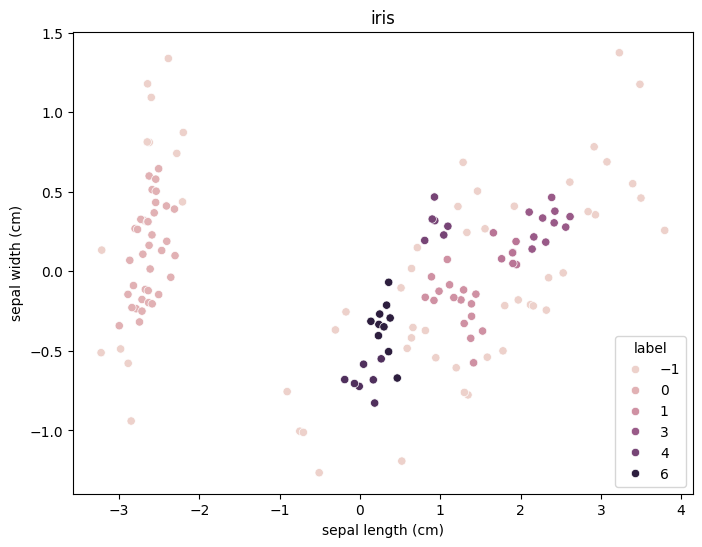


Dataset:  diabetes
Dataset shape:  (442, 2)
Execution Time: 0.11784529685974121
RAM Usage: 3.5
GPU Usage: 3.3
Eps: 0.014765 Min Samples: 6
Number of Core Points: 186
Number of Clusters: 8
Number of Unclassified Points: 185


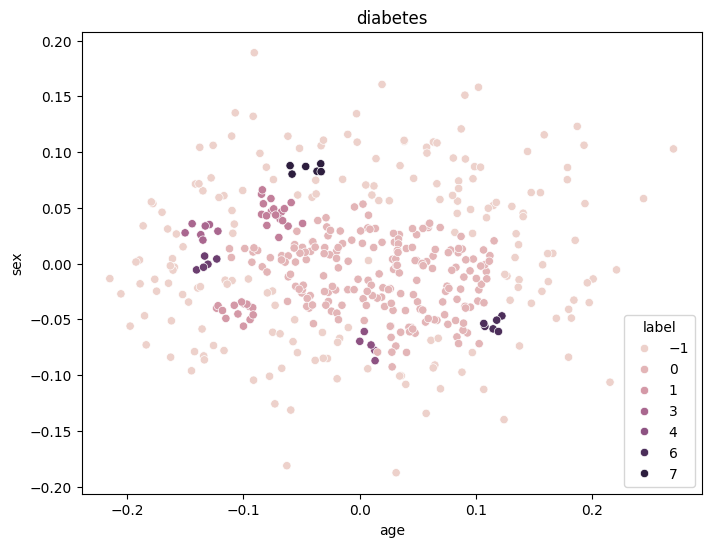


Dataset:  digits
Dataset shape:  (1797, 2)
Execution Time: 0.30536317825317383
RAM Usage: 3.6
GPU Usage: 3.4
Eps: 1.038251 Min Samples: 7
Number of Core Points: 350
Number of Clusters: 36
Number of Unclassified Points: 1109


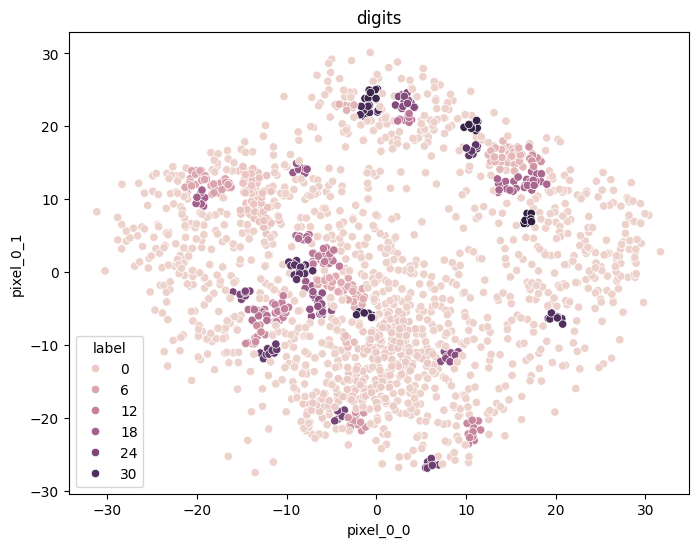


Dataset:  linnerud
Dataset shape:  (20, 2)
Execution Time: 0.12360906600952148
RAM Usage: 3.6
GPU Usage: 3.4
Eps: 41.911597 Min Samples: 2
Number of Core Points: 18
Number of Clusters: 2
Number of Unclassified Points: 2


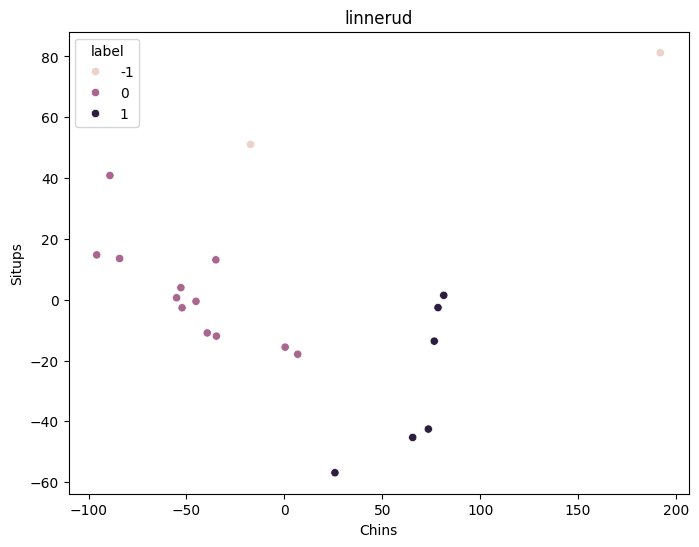


Dataset:  wine
Dataset shape:  (178, 2)
Execution Time: 0.12151598930358887
RAM Usage: 3.6
GPU Usage: 3.4
Eps: 16.622963 Min Samples: 5
Number of Core Points: 90
Number of Clusters: 7
Number of Unclassified Points: 62


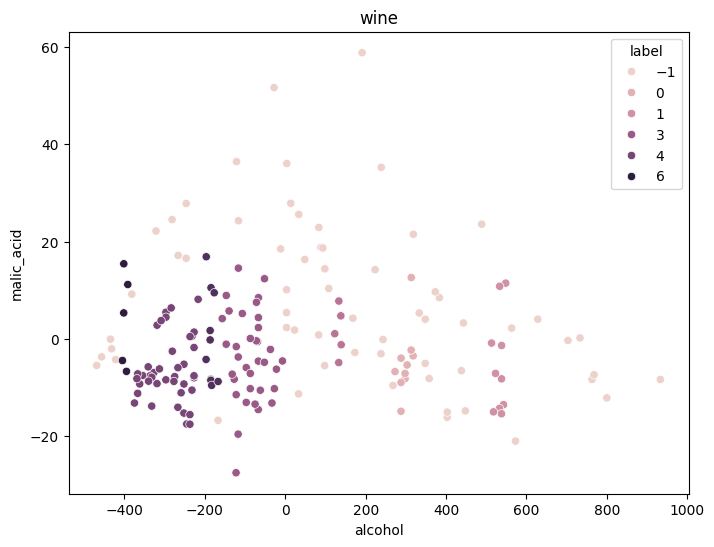


Dataset:  breast_cancer
Dataset shape:  (569, 2)
Execution Time: 0.129866361618042
RAM Usage: 3.6
GPU Usage: 3.3
Eps: 42.689478 Min Samples: 6
Number of Core Points: 392
Number of Clusters: 5
Number of Unclassified Points: 138


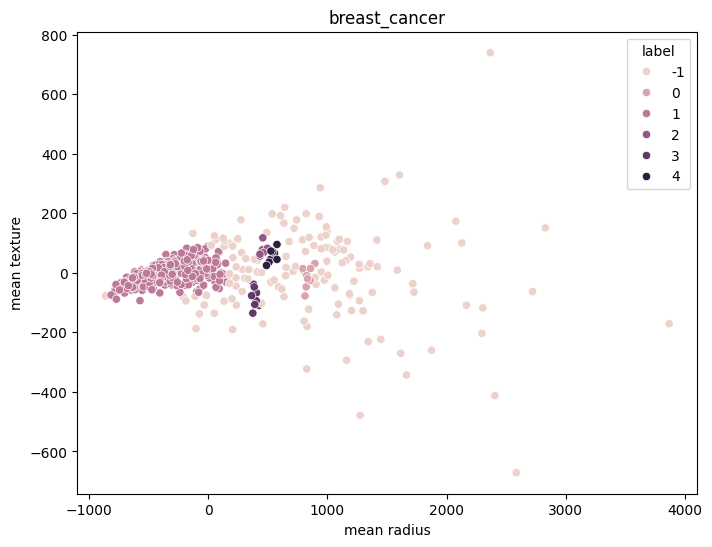

In [ ]:
# Declarar del diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                      'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                      'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                      'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                      'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                      'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                    }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():

    # Obtener el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data
    Y = np.ascontiguousarray(Y) # Es importante asegurarse que el arreglo sea contiguo para evitar problemas al copiar a la VRAM
    x_1 = toy_datasets[dataset_name]['dataset'].feature_names[0]
    x_2 = toy_datasets[dataset_name]['dataset'].feature_names[1]

    # Reducir dimensión a dos entradas
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)
    X_std = np.ascontiguousarray(X_std)

    # Eliminar las variables auxiliares para transformar el dataset
    del Y, pca
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Obtener el timpo inicial
    start_time = time.time()

    # Ejecutar DBSCAN con los valores eps y min_samples correspondientes
    assignment, core_set, gpu_memory_info = dbscan (eps, min_samples, X_std)

    # Obtener el tiempo final y se lleva a cabo la diferenica para obtener el tiempo de ejecución
    execution_time = time.time() - start_time

    # Procesar resultados
    labels = [-1] * len (X_std)
    for i, c in assignment.items ():
        labels[i] = c

    # Print and plot results
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X_std.shape)
    print("Execution Time:", execution_time)
    print("RAM Usage:", get_memory_usage_percentage())
    print("GPU Usage:", gpu_memory_info)
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", len (core_set))
    print("Number of Clusters:", max(assignment.values ())+1)
    print("Number of Unclassified Points:", list(labels).count(-1))

    # Graficar clusters para visualización
    df = pd.DataFrame(X_std, columns=[x_1, x_2])
    plot_labels(df, labels, dataset_name)

  ## Experimentación con Toy Datasets con DBSCAN paralelo

A continuación, se lleva a cabo la experimentación con los conjuntos de datos de muestra de la librería `sklearn` llamados [Toy Datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html).

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo son agregados como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `parallel_toy_datasets_results.json`.

In [ ]:
# Declarar diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5},
                  'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                  'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                  'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                  'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                  'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', dataset_name)

    # Cargar el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data
    Y = np.ascontiguousarray(Y)

    # Reducir la dimensión del conjunto de datos a sólo dos características
    pca = PCA(n_components=2)
    X_std = pca.fit_transform(Y)
    X_std = np.ascontiguousarray(X_std)

    # Eliminar variables auxiliares usadas para transformar el dataset
    del Y, toy_datasets[dataset_name]['dataset'], pca
    gc.collect()

    # Obtener los valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Almacenar la forma (dimensionalidad) del conjunto de datos e inicializar el diccionario de experimentos
    toy_datasets[dataset_name]['shape'] = X_std.shape
    toy_datasets[dataset_name]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(3):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      assignment, core_set, gpu_memory_info = dbscan (eps, min_samples, X_std)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Procesar resultados
      labels = [-1] * len (X_std)
      for j, c in assignment.items ():
          labels[j] = c

      # Save results
      toy_datasets[dataset_name]["experiment"][i] = {
          "execution_time": execution_time,
          "memory_usage": get_memory_usage_percentage(),
          "gpu_memory_usage": gpu_memory_info,
          "clusters": max(assignment.values ())+1,
          "core_points": len(core_set),
          "unclassified_points": list(labels).count(-1),
          "labels": labels
      }

      # Eliminar los resultados de DBSCAN de la memoria RAM
      del assignment, core_set, labels
      gc.collect()

    # Eliminar el conjunto de datos en Y y en X_std de la memoria RAM
    del X_std
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'parallel_toy_datasets_results.json'
with open(file_name, 'w') as file:
    json.dump(toy_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  iris


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 100 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Dataset:  diabetes
Dataset:  digits
Dataset:  linnerud


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Dataset:  wine
Dataset:  breast_cancer
Resultados guardados en parallel_toy_datasets_results.json


## Aplicación DBSCAN Paralelo a conjuntos de datos sintéticos de distintos tamaños

A continuación, se ejecuta el algoritmo dbscan **paralelo** con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets` y se grafican los resultados.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de la ejecución se imprimen y se grafican.


Dataset:  5000
Dataset shape:  (5000, 2)
Execution Time: 1.7148473262786865
RAM Usage: 3.9
VRAM Usage: 3.5
Eps: 0.4 Min Samples: 6
Number of Core Points: 4881
Number of Clusters: 2
Number of Unclassified Points: 65


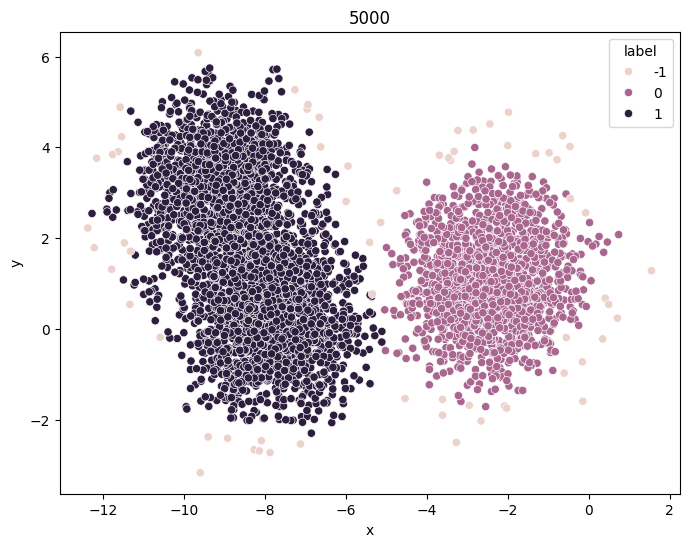


Dataset:  10000
Dataset shape:  (10000, 2)
Execution Time: 6.751080513000488
RAM Usage: 4.3
VRAM Usage: 4.1
Eps: 0.6 Min Samples: 5
Number of Core Points: 9957
Number of Clusters: 3
Number of Unclassified Points: 13


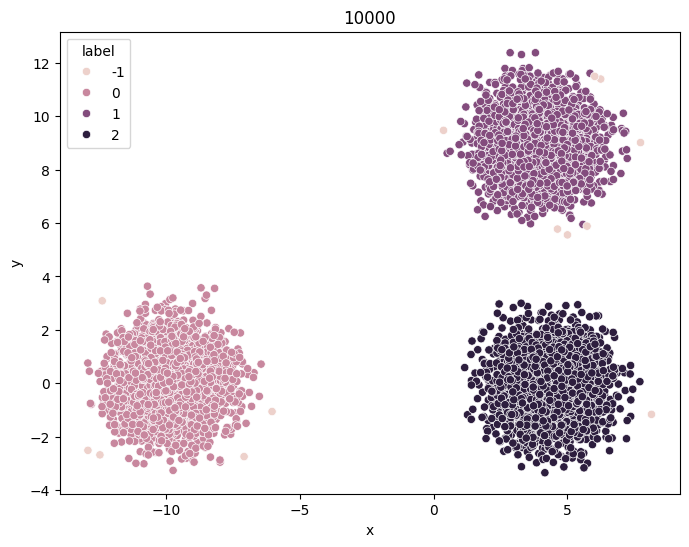


Dataset:  15000
Dataset shape:  (15000, 2)
Execution Time: 15.712589979171753
RAM Usage: 6.0
VRAM Usage: 5.4
Eps: 0.8 Min Samples: 4
Number of Core Points: 14994
Number of Clusters: 2
Number of Unclassified Points: 2


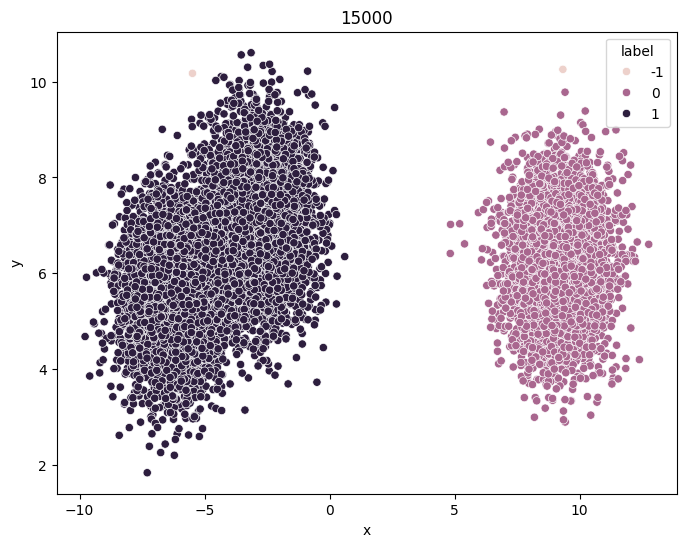


Dataset:  20000
Dataset shape:  (20000, 2)
Execution Time: 29.22579574584961
RAM Usage: 6.5
VRAM Usage: 5.7
Eps: 0.8 Min Samples: 6
Number of Core Points: 19985
Number of Clusters: 2
Number of Unclassified Points: 2


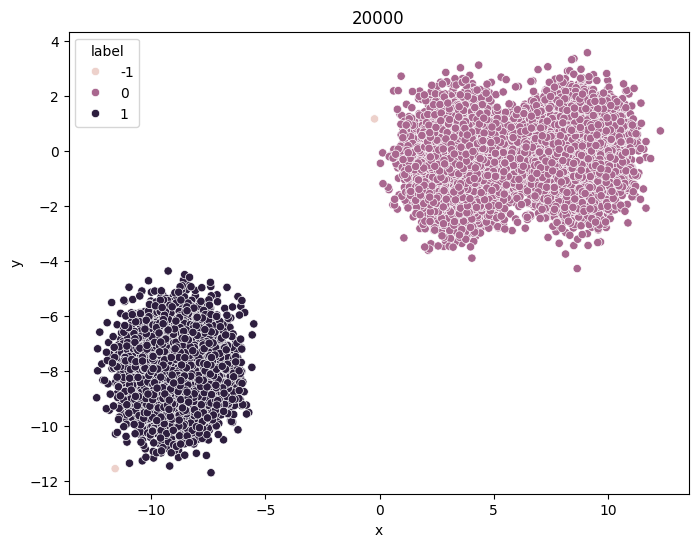


Dataset:  25000
Dataset shape:  (25000, 2)
Execution Time: 47.837440729141235
RAM Usage: 8.5
VRAM Usage: 9.3
Eps: 0.9 Min Samples: 4
Number of Core Points: 24990
Number of Clusters: 2
Number of Unclassified Points: 2


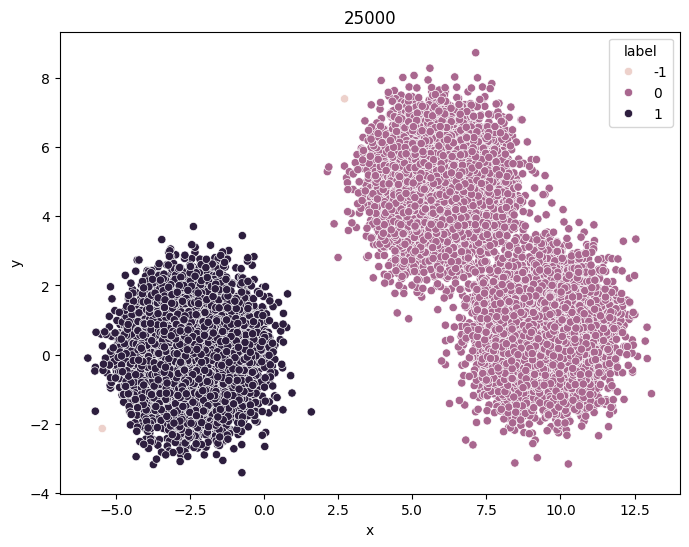


Dataset:  30000
Dataset shape:  (30000, 2)
Execution Time: 66.5043158531189
RAM Usage: 9.3
VRAM Usage: 14.6
Eps: 0.8 Min Samples: 2
Number of Core Points: 29998
Number of Clusters: 2
Number of Unclassified Points: 2


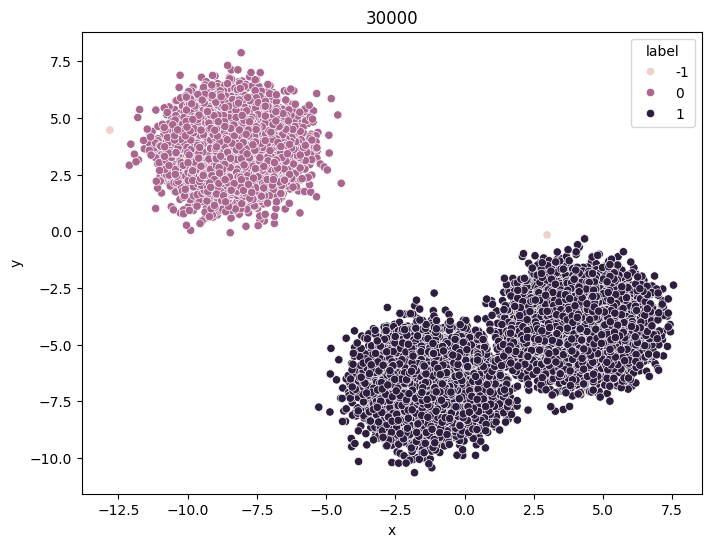


Dataset:  35000
Dataset shape:  (35000, 2)
Execution Time: 90.40829992294312
RAM Usage: 10.7
VRAM Usage: 21.7
Eps: 0.8 Min Samples: 3
Number of Core Points: 34991
Number of Clusters: 2
Number of Unclassified Points: 4


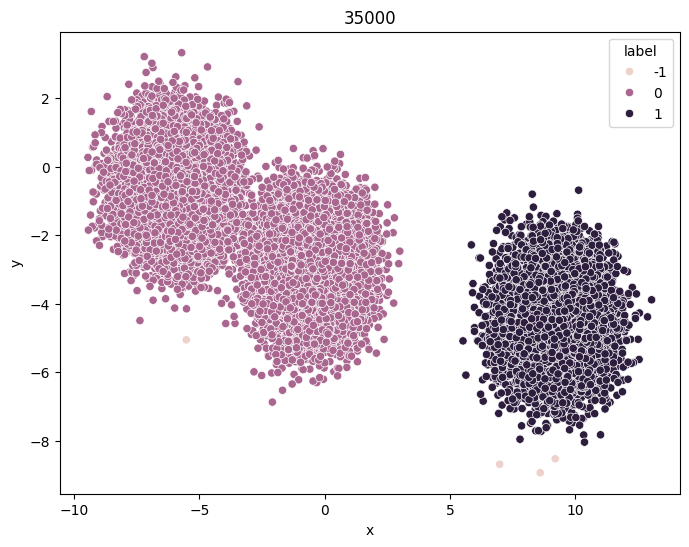


Dataset:  40000
Dataset shape:  (40000, 2)
Execution Time: 115.10865068435669
RAM Usage: 15.1
VRAM Usage: 19.8
Eps: 0.8 Min Samples: 5
Number of Core Points: 39983
Number of Clusters: 2
Number of Unclassified Points: 6


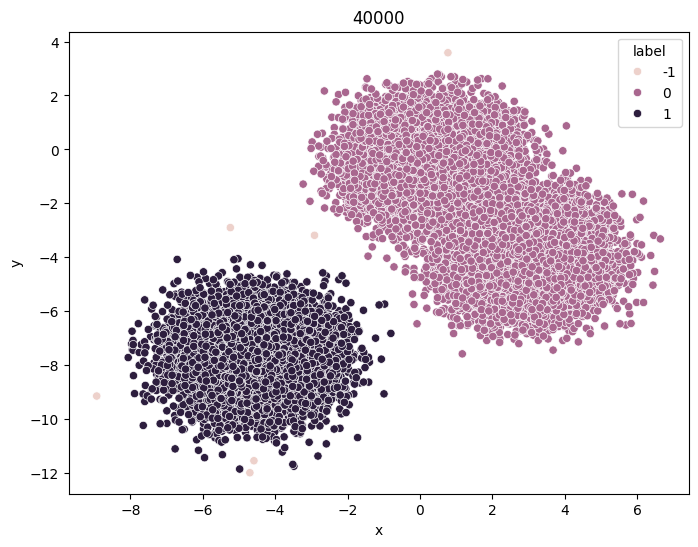


Dataset:  45000
Dataset shape:  (45000, 2)
Execution Time: 141.19596314430237
RAM Usage: 17.3
VRAM Usage: 31.6
Eps: 0.8 Min Samples: 9
Number of Core Points: 44974
Number of Clusters: 2
Number of Unclassified Points: 6


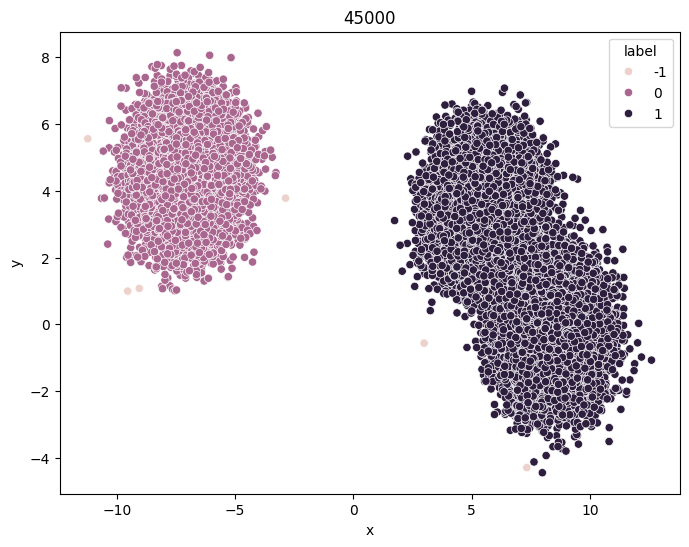


Dataset:  50000
Dataset shape:  (50000, 2)
Execution Time: 166.67038321495056
RAM Usage: 17.9
VRAM Usage: 17.9
Eps: 0.6 Min Samples: 6
Number of Core Points: 49943
Number of Clusters: 3
Number of Unclassified Points: 19


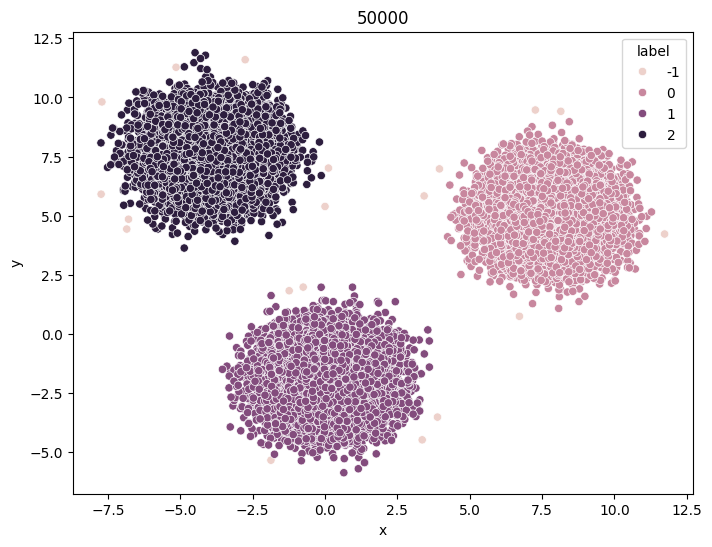

In [ ]:
# Declarar los valores de eps y num_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {5000: {'epsilon': 0.4, 'min_samples': 6},
 10000: {'epsilon': 0.6, 'min_samples': 5},
 15000: {'epsilon': 0.8, 'min_samples': 4},
 20000: {'epsilon': 0.8, 'min_samples': 6},
 25000: {'epsilon': 0.9, 'min_samples': 4},
 30000: {'epsilon': 0.8, 'min_samples': 2},
 35000: {'epsilon': 0.8, 'min_samples': 3},
 40000: {'epsilon': 0.8, 'min_samples': 5},
 45000: {'epsilon': 0.8, 'min_samples': 9},
 50000: {'epsilon': 0.6, 'min_samples': 6}}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Eliminar data de la memoria RAM
    del data
    gc.collect()

    # Obtener tiempo inicial
    start_time = time.time()

    # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
    assignment, core_set, gpu_memory_info = dbscan (eps, min_samples, X)

    # Obtener el tiempo final y la diferencia para obtener el tiempo
    execution_time = time.time() - start_time

    # Procesar resultados
    labels = [-1] * len (X)
    for i, c in assignment.items ():
        labels[i] = c

    # Imprimir resultados
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X.shape)
    print("Execution Time:", execution_time)
    print("RAM Usage:", get_memory_usage_percentage())
    print("VRAM Usage:", gpu_memory_info)
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", len (core_set))
    print("Number of Clusters:", max(assignment.values ())+1)
    print("Number of Unclassified Points:", list(labels).count(-1))

    # Graficar clusters para visualización
    df = pd.DataFrame(X, columns=['x', 'y'])
    plot_labels(df, labels, str(num_samples))

    # Eliminar variables de la memoria RAM
    del X, assignment, core_set, labels
    gc.collect()

## Experimentación de DBSCAN Paralelo con conjuntos de datos sintéticos de distintos tamaños

A continuación, se lleva a cabo la experimentación con los conjuntos de datos sintéticos de distintos tamaños: 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000 y 50000 puntos de dos dimensiones que se generaron utilizando la función `make_blobs` de la librería `sklearn.datasets`.

Los valores óptimos de `eps` y `min_samples` de DBSCAN para cada conjunto de datos fue calculado previamente y sólo es agregado como un valor constante para su utilización en esta experimentación.

Los resultados de este experimento se guardan en el archivo `parallel_different_size_results.json`.

In [ ]:
# Declarar los valores de eps y min_samples óptimos para cada conjunto de datos
datasets_eps_min_samples = {  5000: {'epsilon': 0.4, 'min_samples': 6},
                              10000: {'epsilon': 0.6, 'min_samples': 5},
                              15000: {'epsilon': 0.8, 'min_samples': 4},
                              20000: {'epsilon': 0.8, 'min_samples': 6},
                              25000: {'epsilon': 0.9, 'min_samples': 4},
                              30000: {'epsilon': 0.8, 'min_samples': 2},
                              35000: {'epsilon': 0.8, 'min_samples': 3},
                              40000: {'epsilon': 0.8, 'min_samples': 5},
                              45000: {'epsilon': 0.8, 'min_samples': 9},
                              50000: {'epsilon': 0.6, 'min_samples': 6} }

# Declarar diccionario para almacenar los resultados de la experimentación
different_size_datasets = {}

# Iterar por cada conjunto de datos
for num_samples in range(5000, 50001, 5000):

    # Imprimir el nombre del conjunto de datos para el control de la ejecución
    print('Dataset: ', num_samples)

    # Construir el nombre del archivo JSON del dataset correspondiente
    filename = './datasets/dataset_' + str(num_samples) + '.json'

    # Abrir el archivo JSON correspondiente para cargar los datos del conjunto de datos correspondiente
    with open(filename, 'r') as f:
        data = json.load(f)

    # Obtener los datos, el valor eps y min_samples
    dataset_name = str(num_samples)
    X = np.array(data[dataset_name])
    eps = datasets_eps_min_samples[num_samples]['epsilon']
    min_samples = datasets_eps_min_samples[num_samples]['min_samples']

    # Borrar data de la memoria RAM
    del data
    gc.collect()

    # Guardar los resultados en el diccionario
    different_size_datasets[num_samples] = {}
    different_size_datasets[num_samples]['experiment'] = {}

    # Repetir el experimento para poder verificar que siempre de los mismos resultados el algoritmo DBSCAN
    # y obtener tiempos de ejecución y uso de memoria.
    for i in range(2):

      # Obtener tiempo inicial
      start_time = time.time()

      # Ejecutar DBSCAN con los valores de eps y min_samples correspondientes
      assignment, core_set, gpu_memory_info = dbscan (eps, min_samples, X)

      # Obtener el tiempo final y la diferencia para obtener el tiempo de ejecución
      execution_time = time.time() - start_time

      # Guardar los resultados en el diccionario
      different_size_datasets[num_samples]["experiment"][i] = {
          "execution_time": execution_time,
          "cpu_memory": get_memory_usage_percentage(),
          "gpu_memory": gpu_memory_info,
          "clusters": max(assignment.values ())+1,
          "core_points": len (core_set)
      }

      # Eliminar variables de la memoria RAM
      del assignment, core_set, gpu_memory_info
      gc.collect()

    # Eliminar variables de la memoria RAM
    del X
    gc.collect()

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'parallel_different_size_results.json'
with open(file_name, 'w') as file:
    json.dump(different_size_datasets, file, indent=4)
    print(f"Resultados guardados en {file_name}")

Dataset:  5000
Dataset:  10000
Dataset:  15000
Dataset:  20000
Dataset:  25000
Dataset:  30000
Dataset:  35000
Dataset:  40000
Dataset:  45000
Dataset:  50000
Resultados guardados en parallel_different_size_results.json
